# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [71]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.sql import Window
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Our first Python Spark SQL example") \
    .getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'Our first Python Spark SQL example'),
 ('spark.driver.port', '39067'),
 ('spark.app.id', 'local-1579180206681'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '8c235591ebc4'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
path = "./mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [7]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Dropping all missing values, records without session id and user id

In [9]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [10]:
user_log_valid.count()

286500

In [11]:
user_log.count()

286500

In [12]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [13]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [14]:
user_log.count()- user_log_valid.count()

8346

In [15]:
print("We removed {} records due to them having a blank user id column".format(user_log.count()- user_log_valid.count()))

We removed 8346 records due to them having a blank user id column


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [17]:
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [18]:
user_log_valid = user_log_valid.withColumn("cancelled", flag_cancellation_event("page"))

In [19]:
churned_rate = user_log_valid.groupby("userId").agg({"cancelled": "sum"}).select(avg("sum(cancelled)")).collect()[0]["avg(sum(cancelled))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 23.11%


In [20]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [21]:
phase = user_log_valid.withColumn("phase", Fsum("cancelled").over(windowval))

In [22]:
df_churn = phase.withColumn("churn", Fmax('cancelled').over(Window.partitionBy("userId")))

In [101]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_churn = df_churn.withColumn("time", get_time(df_churn.ts))

In [102]:
df_churn.select("time").describe().show()

+-------+-------------------+
|summary|               time|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



In [100]:
df_churn.filter(df_churn["churn"] == 1).select(["userId", "gender", "level", "page", "status", "ts", "phase", "churn"]).show(20)

+------+------+-----+--------------------+------+-------------+-----+-----+
|userId|gender|level|                page|status|           ts|phase|churn|
+------+------+-----+--------------------+------+-------------+-----+-----+
|   125|     M| free|              Cancel|   307|1539318918000|    1|    1|
|   125|     M| free|Cancellation Conf...|   200|1539318918000|    1|    1|
|   125|     M| free|         Roll Advert|   200|1539318917000|    1|    1|
|   125|     M| free|            NextSong|   200|1539318906000|    1|    1|
|   125|     M| free|            NextSong|   200|1539318728000|    1|    1|
|   125|     M| free|            NextSong|   200|1539318515000|    1|    1|
|   125|     M| free|            NextSong|   200|1539318124000|    1|    1|
|   125|     M| free|            NextSong|   200|1539317914000|    1|    1|
|   125|     M| free|            NextSong|   200|1539317711000|    1|    1|
|   125|     M| free|            NextSong|   200|1539317481000|    1|    1|
|   125|    

In [103]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_churn = df_churn.withColumn("hour", get_hour(df_churn.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df_churn = df_churn.withColumn("weekday", get_weekday(df_churn.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_churn = df_churn.withColumn("day", get_day(df_churn.ts))

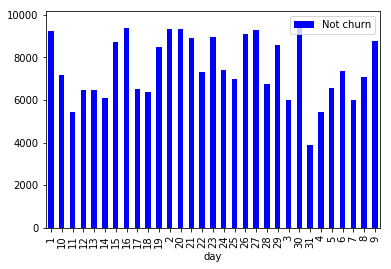

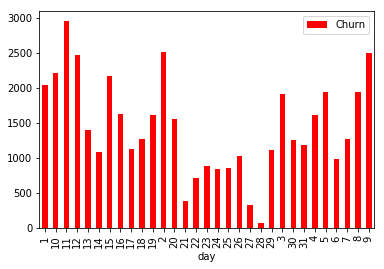

In [104]:
df_time = df_churn.groupby("churn", "day").count().orderBy("day").toPandas()
df_time["day"] = pd.to_numeric(df_time["day"])
df_time[df_time.churn==0].plot.bar(x="day", y='count', color='Blue', label='Not churn')
df_time[df_time.churn==1].plot.bar(x="day", y='count', color='Red', label='Churn')

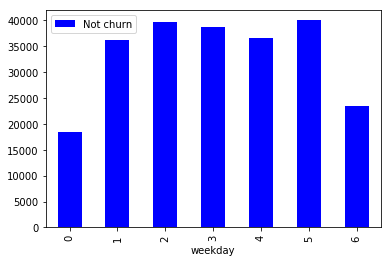

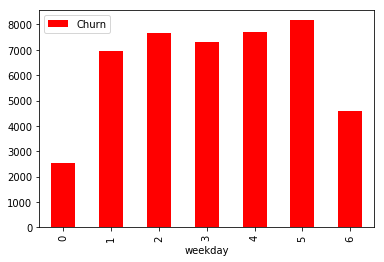

In [105]:
df_time = df_churn.groupby("churn", "weekday").count().orderBy("weekday").toPandas()
df_time["weekday"] = pd.to_numeric(df_time["weekday"])
df_time[df_time.churn==0].plot.bar(x="weekday", y='count', color='Blue', label='Not churn')
df_time[df_time.churn==1].plot.bar(x="weekday", y='count', color='Red', label='Churn')

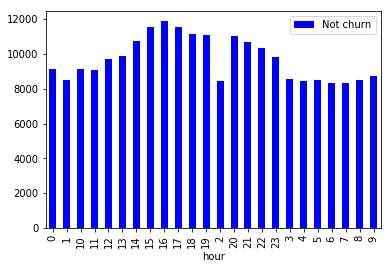

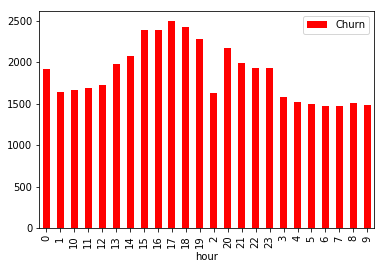

In [106]:
df_time = df_churn.groupby("churn", "hour").count().orderBy("hour").toPandas()
df_time["hour"] = pd.to_numeric(df_time["hour"])
df_time[df_time.churn==0].plot.bar(x="hour", y='count', color='Blue', label='Not churn')
df_time[df_time.churn==1].plot.bar(x="hour", y='count', color='Red', label='Churn')

In [24]:
# method,lastname,SessionId, Registration,userAgent.FirstName, auth (using the cancelled confirmation isntead) doesn't seem to be 
# important in our analys

# we will leave location out for now

df_churn.select("registration").dropDuplicates().show()
df_churn.select("userAgent").dropDuplicates().show()

+-------------+
| registration|
+-------------+
|1529027541000|
|1533192032000|
|1537779419000|
|1534627466000|
|1535389443000|
|1536642109000|
|1537167593000|
|1536854322000|
|1533908361000|
|1536817381000|
|1536663902000|
|1537672236000|
|1536956945000|
|1537611935000|
|1537751138000|
|1533532298000|
|1537057938000|
|1537964483000|
|1528772084000|
|1537440271000|
+-------------+
only showing top 20 rows

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [108]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
number_users=user_log_valid.select("userId").dropDuplicates().count()
print("Number of users: {}".format(number_users))
print("Churned user count: {}".format(churned_user_count))
print("Churned user rate: {:.2f}%".format(churned_user_count / number_users * 100))

Number of users: 225
Churned user count: 52
Churned user rate: 23.11%


In [109]:
# Data Exploration

In [28]:
gender_df=df_churn.select("userId","gender").dropDuplicates()
gender_df.groupby("gender").agg({"gender": "count"}).show()

+------+-------------+
|gender|count(gender)|
+------+-------------+
|     F|          104|
|     M|          121|
+------+-------------+



In [29]:
churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

In [30]:
df_churn_user = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

In [31]:
pd_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", churn_label("churn")).dropDuplicates().toPandas()
pd_gender.head()

,userId,gender,churn
0,154,F,Not Churn
1,300022,M,Not Churn
2,100025,F,Churn
3,36,F,Not Churn
4,300020,F,Not Churn


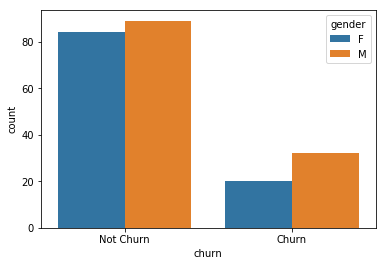

In [32]:
import seaborn as sns
sns.countplot(x="churn", hue="gender", data=pd_gender);

In [33]:
pd_level = df_churn.select(["userId", "level", "churn"]).withColumn("churn", churn_label("churn")).dropDuplicates().toPandas()
pd_level.head()

,userId,level,churn
0,200009,paid,Not Churn
1,24,free,Not Churn
2,11,paid,Not Churn
3,200014,paid,Not Churn
4,105,free,Churn


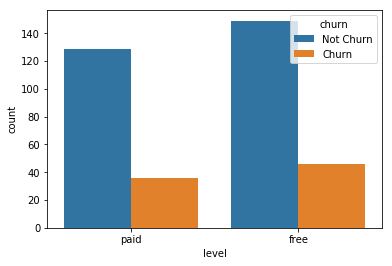

In [34]:
sns.countplot(x="level", hue="churn", data=pd_level);

In [35]:
# Top 10 songs
df_churn.groupby("song").count().sort(desc("count")).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|50046|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
+--------------------+-----+
only showing top 20 rows



In [36]:
# Top 10 artists
artists=df_churn.groupby("artist").count().withColumnRenamed("count", "count").sort(desc("count")).toPandas()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [53]:
df_original = df_churn.groupby('userId','gender'
#                                ,'level'
                              ).max("churn").withColumnRenamed("max(churn)", "target")
df_original.show()

+------+------+------+
|userId|gender|target|
+------+------+------+
|100010|     F|     0|
|200002|     M|     0|
|   125|     M|     1|
|   124|     F|     0|
|    51|     M|     1|
|     7|     M|     0|
|    15|     M|     0|
|    54|     F|     1|
|   155|     F|     0|
|100014|     M|     1|
|   132|     F|     0|
|   154|     F|     0|
|   101|     M|     1|
|    11|     F|     0|
|   138|     M|     0|
|300017|     F|     0|
|100021|     M|     1|
|    29|     M|     1|
|    69|     F|     0|
|   112|     M|     0|
+------+------+------+
only showing top 20 rows



In [44]:
user_paid = df_churn.groupby("userId", "level").agg(max(df_churn.ts).alias("endTime")).sort("userId")
user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.endTime).alias("last"))
df_level = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.last == user_paid.endTime]).select(user_paid.userId, "level").sort("userId")
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_level=df_level.withColumn("level", flag_level("level")
df_level =df_level.select("userId", df_level.level.cast("int"))

In [45]:
user_artist = df_churn.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
user_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         275|
|200002|         387|
|   125|           8|
|    51|        2111|
|   124|        4079|
+------+------------+
only showing top 5 rows



In [46]:
user_length = df_churn.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
user_length.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



In [47]:
user_song = df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")
user_song.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|100010|       275|
|200002|       387|
|   125|         8|
|    51|      2111|
|   124|      4079|
+------+----------+
only showing top 5 rows



In [48]:
user_thumbs_up = df_churn.select('userId', 'page').where(df_churn.page=="Thumbs Up").groupBy('userId').agg({'page':'count'}).withColumnRenamed('count(page)', 'numThumbsUp')

In [49]:
user_thumbs_up.show(5)

+------+-----------+
|userId|numThumbsUp|
+------+-----------+
|100010|         17|
|200002|         21|
|    51|        100|
|   124|        171|
|     7|          7|
+------+-----------+
only showing top 5 rows



In [50]:
user_thumbs_down = df_churn.select('userId', 'page').where(df_churn.page=="Thumbs Down").groupBy('userId').agg({'page':'count'}).withColumnRenamed('count(page)', 'numThumbsDown')
user_thumbs_down.show(5)

+------+-------------+
|userId|numThumbsDown|
+------+-------------+
|100010|            5|
|200002|            6|
|    51|           21|
|   124|           41|
|     7|            1|
+------+-------------+
only showing top 5 rows



In [51]:
user_session = df_churn.groupby("userId").agg({"sessionId": "count"}).withColumnRenamed("count(sessionId)", "sessionId_count")
user_session.show(5)

+------+---------------+
|userId|sessionId_count|
+------+---------------+
|100010|            381|
|200002|            474|
|   125|             11|
|    51|           2464|
|   124|           4825|
+------+---------------+
only showing top 5 rows



In [128]:
merged_df = df_original \
    .join(user_artist, ['userId']) \
    .join(user_length, ['userId']) \
    .join(user_song, ['userId']) \
    .join(user_thumbs_up, ['userId']) \
    .join(user_thumbs_down, ['userId']) \
    .join(user_session, ['userId']) \
    .join(df_level, ['userId']) \

In [129]:
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
merged_df= merged_df.withColumn("gender", flag_gender("gender"))

In [130]:
merged_df=merged_df.withColumnRenamed("target", "label")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [85]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes


In [86]:
merged_df.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [131]:
merged_df_without_user = merged_df.drop("userId")
feature_columns = [col for col in merged_df_without_user.columns if col!='label']
feature_columns

['gender',
 'artist_count',
 'length',
 'song_count',
 'numThumbsUp',
 'numThumbsDown',
 'sessionId_count',
 'level']

In [135]:
train, rest = merged_df_without_user.randomSplit([0.70, 0.30], seed=42)
validation, test = rest.randomSplit([0.5,0.5], seed=42) 

In [145]:
def train_model(classifier, param):
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler,
                                scaler, 
                                classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='label', metricName='f1'),
        numFolds=2
    )
    return model

In [146]:
from pyspark.ml.regression import LinearRegression

In [147]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="label")
param = ParamGridBuilder().build()
model = train_model(lr, param)

lr_model = model.fit(train)
lr_preds = lr_model.transform(validation)
lr_preds.select('prediction').dropDuplicates().show()
lr_model.avgMetrics

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Logistic Regression Model --- Accuracy is: ")
print(evaluator.evaluate(lr_preds, {evaluator.metricName: "accuracy"}))

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score = evaluator.evaluate(lr_preds, {evaluator.metricName: "f1"})
print("f1: {}".format(f1_score))

+----------+
|prediction|
+----------+
|       0.0|
+----------+

Logistic Regression Model --- Accuracy is: 
0.3333333333333333
f1: 0.16666666666666666


In [ ]:
#Random forest

rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label")
rf_param = ParamGridBuilder().build()
rf_model = train_model(rf, rf_param)


rf_fit_model = rf_model.fit(train)
rf_pred = rf_fit_model.transform(test)
rf_pred.select("prediction").dropDuplicates().show()

In [202]:
# training dataset preds
rf_pred_train = rf_fit_model.transform(train)
rf_f1_score_train = evaluator.evaluate(rf_pred_train, {evaluator.metricName: "f1"})
print("f1: {}".format(rf_f1_score_train))

f1: 0.8312157317938403


In [204]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Random Forest Regression Model --- Accuracy is: ")
print(evaluator.evaluate(rf_pred_train, {evaluator.metricName: "accuracy"}))

Random Forest Regression Model --- Accuracy is: 
0.8561643835616438


In [200]:
# testing
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Random Forest Regression Model --- Accuracy is: ")
print(evaluator.evaluate(rf_pred, {evaluator.metricName: "accuracy"}))

Random Forest Regression Model --- Accuracy is: 
0.7446808510638298


In [148]:
rf_f1_score = evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(rf_f1_score))

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+

Random Forest Regression Model --- Accuracy is: 
0.3333333333333333
f1: 0.6939443535188217


In [ ]:
# Validation
rf_pred_valid = rf_fit_model.transform(validation)
rf_f1_score_valid = evaluator.evaluate(rf_pred_valid, {evaluator.metricName: "f1"})
print("f1: {}".format(rf_f1_score_valid))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Random Forest Regression Model --- Accuracy is: ")
print(evaluator.evaluate(rf_pred_valid, {evaluator.metricName: "accuracy"}))

In [ ]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = feature_columns
feature_importance_df['importance'] = rf_fit_model.bestModel.stages[2].featureImportances.values.tolist()

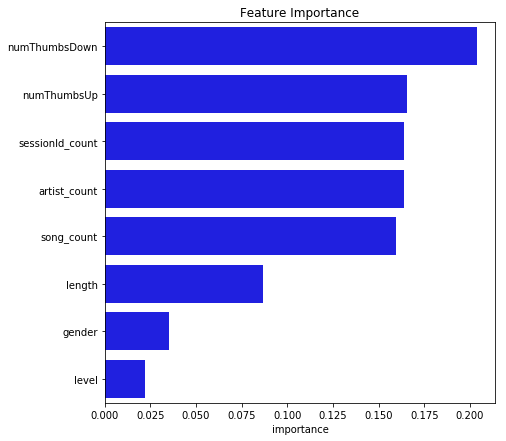

In [199]:
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importance_df

import seaborn as sns
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');


In [ ]:
# GBT
gbt =GBTClassifier(featuresCol="scaled_features", labelCol="label")
gbt_param = ParamGridBuilder().build()
gbt_model = train_model(gbt, gbt_param)
gbt_fit_model = gbt_model.fit(train)
gbt_pred = gbt_fit_model.transform(test)

gbt_pred.select("prediction").dropDuplicates().show()

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("GBT Regression Model --- Accuracy is: ")
print(evaluator.evaluate(gbt_pred, {evaluator.metricName: "accuracy"}))

gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(gbt_f1_score))

In [164]:
gbt_pred_valid = gbt_fit_model.transform(validation)
gbt_f1_score_score = evaluator.evaluate(gbt_pred_valid, {evaluator.metricName: "f1"})
print("f1: {}".format(gbt_f1_score_score))

f1: 0.30000000000000004


+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+

GBT Regression Model --- Accuracy is: 
0.3333333333333333
f1: 0.6761605711977694


In [ ]:
gbt_fit_model.bestModel.stages[2].featureImportances.values.tolist()

In [166]:
gbt_pred_valid.columns

['gender',
 'label',
 'artist_count',
 'length',
 'song_count',
 'numThumbsUp',
 'numThumbsDown',
 'sessionId_count',
 'level',
 'features',
 'scaled_features',
 'rawPrediction',
 'probability',
 'prediction']

In [158]:
feature_columns

['gender',
 'artist_count',
 'length',
 'song_count',
 'numThumbsUp',
 'numThumbsDown',
 'sessionId_count',
 'level']

In [152]:
# Feature Importances

In [189]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = feature_columns

# feature_importance_df['importance'] = gbt_fit_model.bestModel.stages[2].featureImportances.values.tolist()

In [190]:
feature_importance_df['importance'] =[ 0.11043466,  0.23006928,  0.05623603, 0.0, 0.24850505,  0.25471431,
        0.06377691,  0.03626376]

In [191]:
 /feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importance_df

,feature,importance
0,numThumbsDown,0.254714
1,numThumbsUp,0.248505
2,artist_count,0.230069
3,gender,0.110435
4,sessionId_count,0.063777
5,length,0.056236
6,level,0.036264
7,song_count,0.000000


In [192]:
feature_importance_df

,feature,importance
0,numThumbsDown,0.254714
1,numThumbsUp,0.248505
2,artist_count,0.230069
3,gender,0.110435
4,sessionId_count,0.063777
5,length,0.056236
6,level,0.036264
7,song_count,0.000000


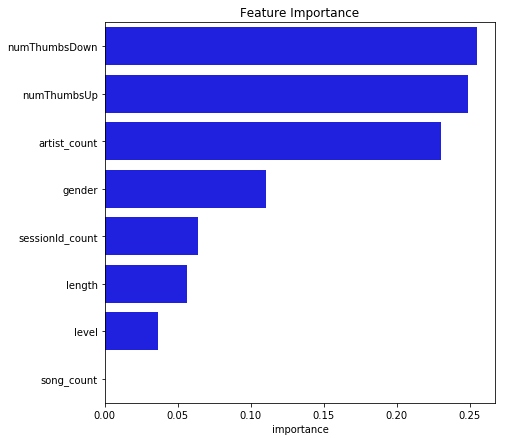

In [193]:
import seaborn as sns
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.